# 🎯 Использование ПИД-регулятора для управления самолетом F-16


Этот пример демонстрирует практическое применение ПИД-регулятора для управления продольным движением самолета F-16. Мы покажем, как настроить регулятор, провести симуляцию и оценить качество управления.

## 📋 Содержание

1. [🚀 Быстрый старт](#быстрый-старт)
2. [⚙️ Настройка параметров](#настройка-параметров)
3. [🎮 Создание среды симуляции](#создание-среды-симуляции)
4. [🔄 Запуск симуляции](#запуск-симуляции)
5. [📊 Анализ результатов](#анализ-результатов)
6. [💡 Советы и рекомендации](#советы-и-рекомендации)

## 🎯 Цель примера

В этом примере мы:
- Создадим ПИД-регулятор с предварительно настроенными параметрами
- Настроим среду симуляции для самолета F-16
- Проведем симуляцию управления углом атаки
- Оценим качество управления с помощью метрик производительности

---

## 🚀 Быстрый старт

Импортируем необходимые библиотеки для работы с ПИД-регулятором и симуляцией.

In [1]:
import numpy as np
import gymnasium as gym

from tensoraerospace.agent.pid import PID
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error

## ⚙️ Настройка параметров

Определяем основные параметры симуляции и коэффициенты ПИД-регулятора.

### Параметры симуляции:
- `dt`: Шаг дискретизации времени (0.01 с)
- `tn`: Общее время симуляции (20 с)
- `reference_signal`: Заданный сигнал (единичный скачок на 5°)

### Коэффициенты ПИД-регулятора:
- `kp`: Пропорциональный коэффициент
- `ki`: Интегральный коэффициент
- `kd`: Дифференциальный коэффициент

In [2]:
# Параметры времени и дискретизации
dt = 0.01  # Шаг дискретизации времени
tp = generate_time_period(tn=20, dt=dt)  # Временной период
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)  # Количество временных шагов

# Создание заданного сигнала (единичный скачок на 5 градусов)
reference_signals = np.reshape(
    unit_step(degree=5, tp=tp, time_step=10, output_rad=True), 
    [1, -1]
)

# Предварительно настроенные коэффициенты ПИД-регулятора
pid_config = {
    'ki': -0.6465002150926438,   # Интегральный коэффициент
    'kp': -20.410120034380714,  # Пропорциональный коэффициент
    'kd': -6.070487412521423    # Дифференциальный коэффициент
}

## 🎮 Создание среды симуляции

Создаем среду симуляции для продольного движения самолета F-16 и инициализируем ПИД-регулятор.

### Параметры среды:
- **Модель**: LinearLongitudinalF16-v0
- **Начальное состояние**: [0, 0, 0] (theta, alpha, q)
- **Отслеживаемое состояние**: alpha (угол атаки)
- **Пространство состояний**: [theta, alpha, q]

> **💡 Совет**: Угол атаки (alpha) является ключевым параметром для управления подъемной силой самолета.

In [3]:
# Обновляем параметры для более длительной симуляции
tp = generate_time_period(tn=80, dt=dt)
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)

# Создание заданного сигнала для длительной симуляции
reference_signals = np.reshape(
    unit_step(degree=5, tp=tp, time_step=10, output_rad=True), 
    [1, -1]
)

# Создание среды симуляции F-16
env = gym.make(
    'LinearLongitudinalF16-v0',
    number_time_steps=number_time_steps,
    use_reward=False,
    initial_state=[[0], [0], [0]],  # [theta, alpha, q]
    reference_signal=reference_signals,
    state_space=["theta", "alpha", "q"],
    output_space=["theta", "alpha", "q"],
    tracking_states=["alpha"]  # Отслеживаем угол атаки
)

# Инициализация среды
env.reset()

# Создание ПИД-регулятора
pid = PID(
    env, 
    kp=pid_config["kp"], 
    ki=pid_config["ki"], 
    kd=pid_config["kd"], 
    dt=dt
)

## 🔄 Запуск симуляции

Запускаем основной цикл симуляции, где ПИД-регулятор управляет углом атаки самолета.

### Алгоритм управления:
1. Получаем текущее состояние системы
2. Сравниваем с заданным значением
3. Вычисляем управляющий сигнал через ПИД-регулятор
4. Применяем управляющий сигнал к системе
5. Повторяем до завершения симуляции

> **⚠️ Внимание**: Во время выполнения могут появиться предупреждения от Gymnasium - это нормально.

In [4]:
# Инициализация списка для хранения истории
hist = []

# Получение начального состояния
xt, info = env.reset()

# Основной цикл симуляции
for step in range(number_time_steps - 2):
    # Получение текущего заданного значения
    setpoint = reference_signals[0, step]
    
    # Сохранение текущего угла атаки в историю
    hist.append(xt[1])
    
    # Вычисление управляющего сигнала через ПИД-регулятор
    ut = pid.select_action(setpoint, xt[1])
    
    # Применение управляющего сигнала к системе
    xt, reward, terminated, truncated, info = env.step(np.array([ut.item()]))

print(f"✅ Симуляция завершена! Выполнено {len(hist)} шагов.")

✅ Симуляция завершена! Выполнено 7999 шагов.


/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


## 📊 Анализ результатов

Извлекаем данные симуляции и вычисляем ключевые метрики производительности системы управления.

### Метрики качества управления:
- **Статическая ошибка**: Разность между заданным и установившимся значением
- **Перерегулирование**: Максимальное превышение заданного значения (%)
- **Время установления**: Время достижения установившегося режима (с)

In [5]:
# Извлечение данных симуляции
system_signal_orig = env.unwrapped.model.get_state('alpha', to_deg=True)[:4000]
control_signal_orig = np.rad2deg(reference_signals[0])[:4000]

print("📈 Данные симуляции извлечены успешно!")
print(f"📏 Длина сигнала системы: {len(system_signal_orig)} точек")
print(f"📏 Длина управляющего сигнала: {len(control_signal_orig)} точек")

📈 Данные симуляции извлечены успешно!
📏 Длина сигнала системы: 4000 точек
📏 Длина управляющего сигнала: 4000 точек


### 📊 Вычисление статической ошибки

Статическая ошибка показывает, насколько точно система достигает заданного значения в установившемся режиме.

In [6]:
# Расчет статической ошибки
static_err = static_error(control_signal_orig, system_signal_orig)
print(f"📊 Статическая ошибка: {static_err:.4f}°")

# Интерпретация результата
if abs(static_err) < 0.5:
    print("✅ Отличная точность! Статическая ошибка минимальна.")
elif abs(static_err) < 1.0:
    print("✅ Хорошая точность. Статическая ошибка приемлема.")
else:
    print("⚠️ Статическая ошибка значительна. Рекомендуется настройка регулятора.")

static_err

📊 Статическая ошибка: 0.1381°
✅ Отличная точность! Статическая ошибка минимальна.


0.13808902269497914

### 📈 Вычисление перерегулирования

Перерегулирование характеризует максимальное превышение системой заданного значения.

In [7]:
# Расчет перерегулирования
overshoot_val = overshoot(control_signal_orig, system_signal_orig)
print(f"📊 Перерегулирование: {overshoot_val:.2f}%")

# Интерпретация результата
if abs(overshoot_val) < 5:
    print("✅ Отличная стабильность! Перерегулирование минимально.")
elif abs(overshoot_val) < 15:
    print("✅ Хорошая стабильность. Перерегулирование приемлемо.")
else:
    print("⚠️ Значительное перерегулирование. Рекомендуется уменьшить Kp или увеличить Kd.")

overshoot_val

📊 Перерегулирование: -2.60%
✅ Отличная стабильность! Перерегулирование минимально.


-2.6043765026611254

### ⏱️ Вычисление времени установления

Время установления показывает, как быстро система достигает установившегося режима.

In [8]:
# Расчет времени установления
settling_time_val = settling_time(control_signal_orig, system_signal_orig) * 0.01
print(f"📊 Время установления: {settling_time_val:.2f} с")

# Интерпретация результата
if settling_time_val < 5:
    print("✅ Отличная скорость отклика! Система быстро достигает установившегося режима.")
elif settling_time_val < 15:
    print("✅ Хорошая скорость отклика.")
else:
    print("⚠️ Медленная скорость отклика. Рекомендуется увеличить Kp или уменьшить Ki.")

settling_time_val

📊 Время установления: 17.61 с
⚠️ Медленная скорость отклика. Рекомендуется увеличить Kp или уменьшить Ki.


17.61

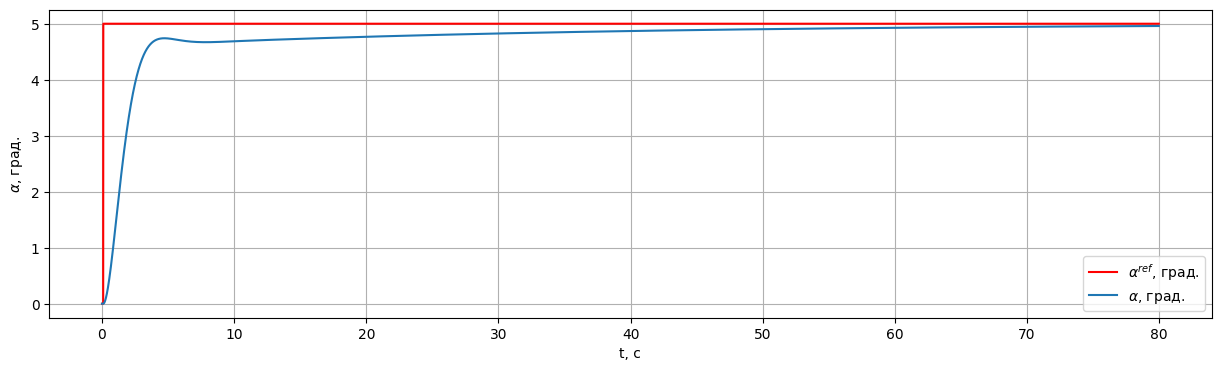

In [9]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


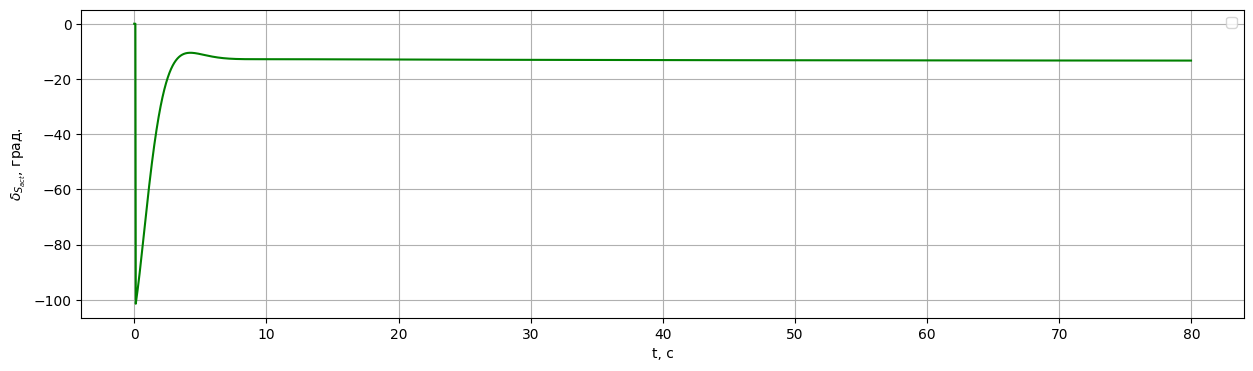

In [10]:
env.unwrapped.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

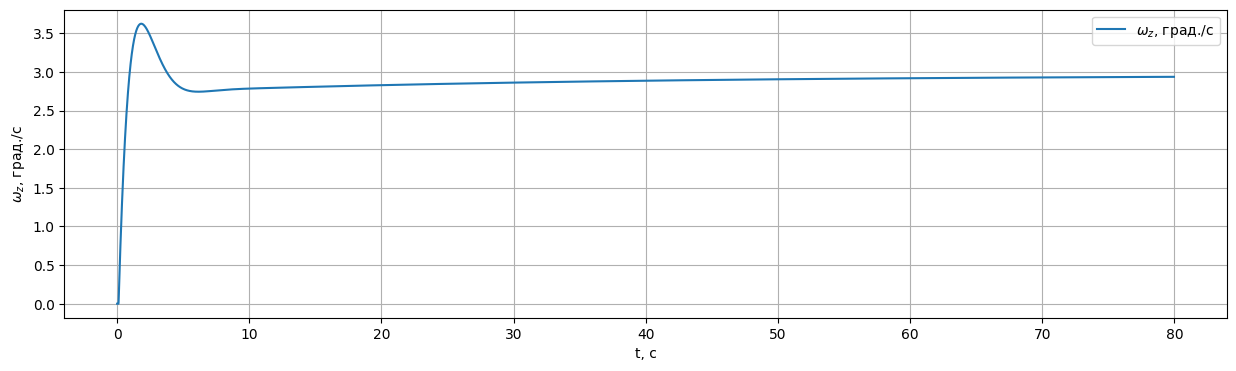

In [11]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

## 💡 Советы и рекомендации

### 🎛️ Настройка ПИД-регулятора

**Пропорциональный коэффициент (Kp):**
- ⬆️ Увеличение: Быстрее отклик, но больше перерегулирование
- ⬇️ Уменьшение: Медленнее отклик, но стабильнее система

**Интегральный коэффициент (Ki):**
- ⬆️ Увеличение: Устраняет статическую ошибку, но может вызвать колебания
- ⬇️ Уменьшение: Более стабильная система, но возможна статическая ошибка

**Дифференциальный коэффициент (Kd):**
- ⬆️ Увеличение: Уменьшает перерегулирование и колебания
- ⬇️ Уменьшение: Может увеличить перерегулирование

### 🔧 Методы настройки

1. **Метод Циглера-Николса**: Классический подход для первоначальной настройки
2. **Метод проб и ошибок**: Постепенная корректировка параметров
3. **Автоматическая настройка**: Использование алгоритмов оптимизации

### 📚 Дополнительные ресурсы

- [Документация TensorAeroSpace](https://tensoraerospace.readthedocs.io/)
- [Теория управления](https://en.wikipedia.org/wiki/PID_controller)

### 🚀 Следующие шаги

1. Попробуйте изменить коэффициенты ПИД и посмотрите на результат
2. Экспериментируйте с различными заданными сигналами
3. Изучите другие типы регуляторов в TensorAeroSpace

---

**🎉 Поздравляем!** Вы успешно освоили основы использования ПИД-регулятора в TensorAeroSpace!

*Если у вас есть вопросы или предложения, создайте issue в [репозитории проекта](https://github.com/TensorAeroSpace/TensorAeroSpace/issues).*